In [1]:
import os
import subprocess

def git_repo_root():
    # Run the 'git rev-parse --show-toplevel' command to get the root directory of the Git repository
    try:
        root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], universal_newlines=True).strip()
        return root
    except subprocess.CalledProcessError:
        # Handle the case where the current directory is not inside a Git repository
        return None

# Get the root directory of the Git repository
git_root = git_repo_root()

if git_root:
    # Change the working directory to the root of the Git repository
    os.chdir(git_root)
    print(f"Changed working directory to: {git_root}")
else:
    print("Not inside a Git repository.")

Changed working directory to: /Users/stephenrobbins/Documents/Documents-Stephens_MacBook_Pro/Python/Random/Diffusion_project


In [2]:

import torch
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

from torch.utils.data import DataLoader


In [3]:
device = 'cpu'

''' hyper params'''
n_epochs =   50
batch_size =  4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


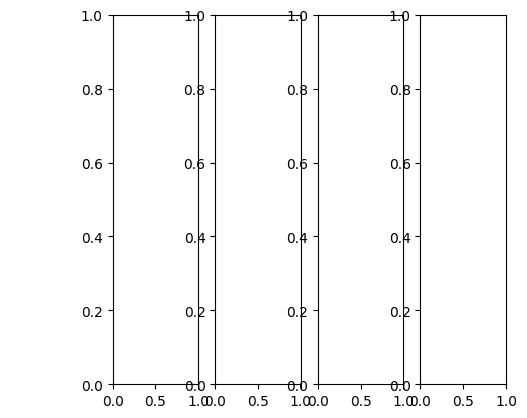

  0%|          | 0/10 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [6]:
%load_ext autoreload
%autoreload 2
from diffusion import BridgeDiffusionVPSDE
from training import train_score_network_mnist
from denoising_diffusion_pytorch import Unet

class CorrectEMNISTOrientation(object):
    def __call__(self, img):
        # Rotate 90 degrees counter-clockwise
        img = transforms.functional.rotate(img, -90)
        # Flip horizontally
        img = transforms.functional.hflip(img)
        return img

tfm = transforms.Compose([transforms.ToTensor(), transforms.Pad(2)])
emnist_tfm = transforms.Compose([transforms.ToTensor(),transforms.Pad(2),CorrectEMNISTOrientation()])

# Load MNIST dataset
mnist_data = torchvision.datasets.MNIST('./data/', transform=tfm, download=True)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

# Load EMNIST dataset
emnist_data = torchvision.datasets.EMNIST('./data/', 'letters', transform=emnist_tfm, download=True)
emnist_loader = DataLoader(emnist_data, batch_size=batch_size, shuffle=True)

def data_y(n):
    # Create a new DataLoader with batch_size = n
    temp_loader = DataLoader(emnist_data, batch_size=n, shuffle=True)

    # Fetch one batch of data
    for data, labels in temp_loader:
        return data # This returns n samples

model = Unet(out_dim=1, channels = 2, dim = 32).to(device)
sde = BridgeDiffusionVPSDE(data_y,  bmin=0.2, bmax=0.2, device = device)
train_score_network_mnist(mnist_loader, model, sde, epochs=10, bridge=True)